In [2]:
import os
import sys
import time

from IPython.display import Audio

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Dropout

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [3]:
Crema = "/home/tai/snap/taimai/bluebelt/dataset/AudioWAV/"

In [4]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head(20)

,Emotions,Path
0,angry,/home/tai/snap/taimai/bluebelt/dataset/AudioWA...
1,neutral,/home/tai/snap/taimai/bluebelt/dataset/AudioWA...
2,happy,/home/tai/snap/taimai/bluebelt/dataset/AudioWA...
3,disgust,/home/tai/snap/taimai/bluebelt/dataset/AudioWA...
4,fear,/home/tai/snap/taimai/bluebelt/dataset/AudioWA...
5,happy,/home/tai/snap/taimai/bluebelt/dataset/AudioWA...
6,disgust,/home/tai/snap/taimai/bluebelt/dataset/AudioWA...
7,neutral,/home/tai/snap/taimai/bluebelt/dataset/AudioWA...
8,sad,/home/tai/snap/taimai/bluebelt/dataset/AudioWA...
9,neutral,/home/tai/snap/taimai/bluebelt/dataset/AudioWA...


In [5]:
Crema_data = pd.concat([Crema_df], axis = 0)

# Shuffle the dataframe using the sample method
Crema_data = Crema_data.sample(frac=1).reset_index(drop=True) 
Crema_data.head()

,Emotions,Path
0,sad,/home/tai/snap/taimai/bluebelt/dataset/AudioWA...
1,disgust,/home/tai/snap/taimai/bluebelt/dataset/AudioWA...
2,neutral,/home/tai/snap/taimai/bluebelt/dataset/AudioWA...
3,sad,/home/tai/snap/taimai/bluebelt/dataset/AudioWA...
4,happy,/home/tai/snap/taimai/bluebelt/dataset/AudioWA...


In [6]:
Crema_data.Emotions.value_counts()

Emotions
sad        1271
disgust    1271
happy      1271
angry      1271
fear       1271
neutral    1087
Name: count, dtype: int64

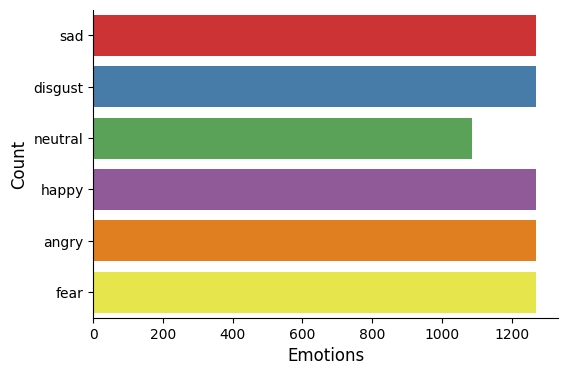

In [7]:
# Visualize the count of each emotion by chart bar, and put color on it.
plt.figure(figsize=(6,4))
sns.countplot(Crema_data.Emotions, palette="Set1")

plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [8]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()


def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    plt.colorbar()

In [9]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=int(pitch_factor * 6))

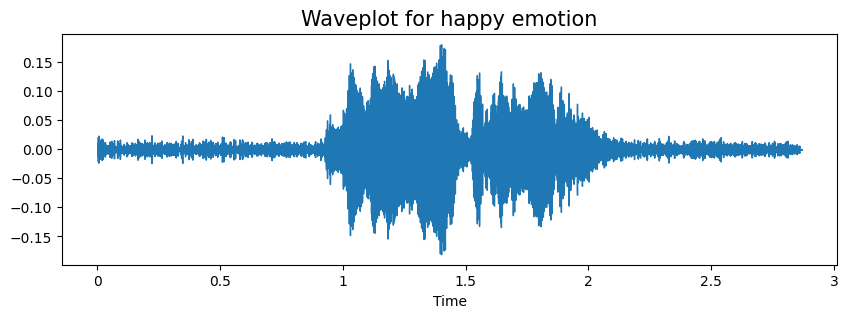

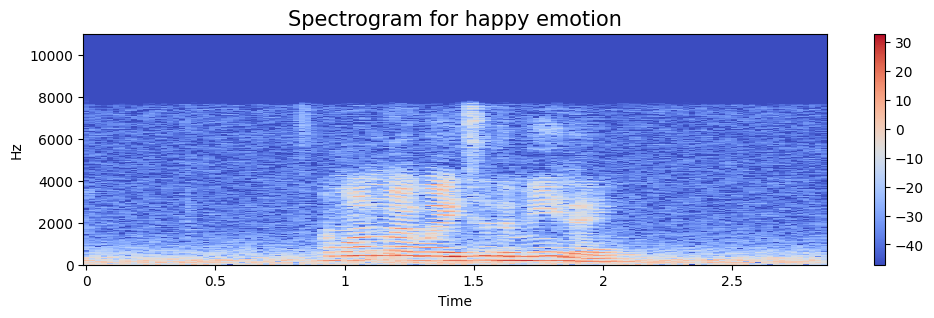

In [10]:
# Key Speech Element Span
# Ravdess_df: 0.8-2.8s -> 2.0s
#    Tess_df: 0.3-1.8s -> 1.5s
#   Savee_df: 0.6-3.3s -> 2.7s

emotion='happy'
path = np.array(Crema_data.Path[Crema_data.Emotions==emotion])[2]
data, sample_rate  = librosa.load(path)

create_waveplot(data, sample_rate, emotion)
create_spectrogram(data, sample_rate, emotion)
Audio(path)

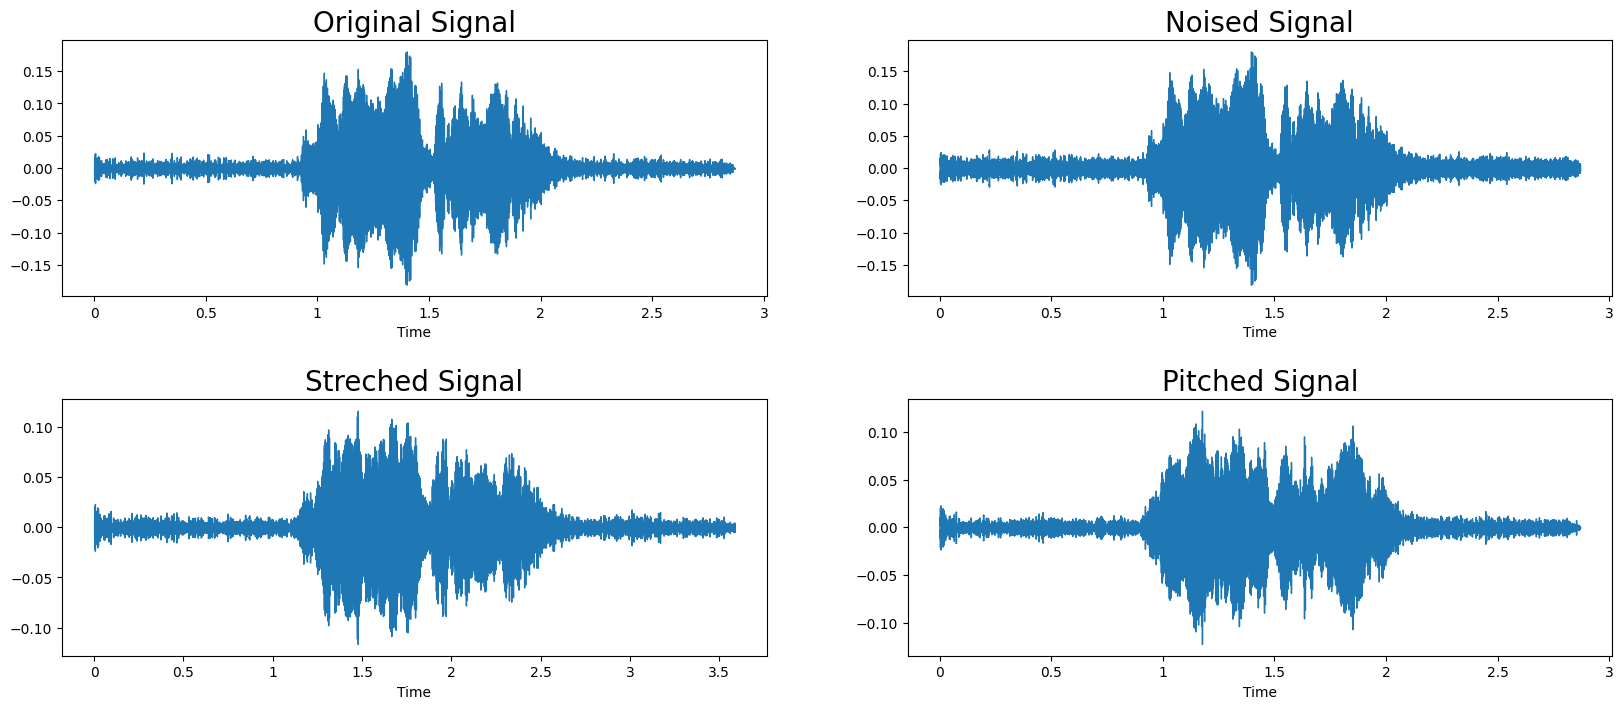

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(20,8))
plt.subplots_adjust(hspace=0.4)

axs[0, 0].set_title('Original Signal', size=20)
librosa.display.waveshow(y=data, sr=sample_rate, ax=axs[0, 0])


axs[0, 1].set_title('Noised Signal', size=20)
noise_data = noise(data)
librosa.display.waveshow(y=noise_data, sr=sample_rate, ax=axs[0, 1])

axs[1, 0].set_title('Streched Signal', size=20)
stretch_data = stretch(data)
librosa.display.waveshow(y=stretch_data, sr=sample_rate, ax=axs[1, 0])

axs[1, 1].set_title('Pitched Signal', size=20)
pitch_data = pitch(data, sample_rate)
librosa.display.waveshow(y=pitch_data, sr=sample_rate, ax=axs[1, 1])

plt.show()

In [13]:
labels = {'neutral':0, 'happy':1, 'disgust':2, 'angry':3, 'sad':4, 'fear':5}
Crema_data.replace({'Emotions':labels},inplace=True)
Crema_data.head()

,Emotions,Path
0,4,/home/tai/snap/taimai/bluebelt/dataset/AudioWA...
1,2,/home/tai/snap/taimai/bluebelt/dataset/AudioWA...
2,0,/home/tai/snap/taimai/bluebelt/dataset/AudioWA...
3,4,/home/tai/snap/taimai/bluebelt/dataset/AudioWA...
4,1,/home/tai/snap/taimai/bluebelt/dataset/AudioWA...


In [14]:
NUM_MFCC = 13
N_FFT = 2048
HOP_LENGTH = 512
SAMPLE_RATE = 22050
DOWN_SAMPLE_RATE = 16000
SAMPLE_NUM = Crema_data.shape[0]

data = {
        "labels": [],
        "features": []
    }

def extract_features(data, sample_rate):
    mfcc = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=NUM_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH)
    feature = mfcc.T
    return feature

for i in range(SAMPLE_NUM):
    for j in range(2):
        data['labels'].append(Crema_data.iloc[i,0])
    signal, sample_rate = librosa.load(Crema_data.iloc[i,1], sr=SAMPLE_RATE)
    
    # Cropping & Resampling
    start_time = 0.4  # Start time in seconds
    end_time = 1.9  # End time in seconds
    start_frame = int(start_time * sample_rate)
    end_frame = int(end_time * sample_rate)
    signal = signal[start_frame:end_frame]
    signal = librosa.resample(signal, orig_sr=sample_rate, target_sr=DOWN_SAMPLE_RATE)
    
    # Add noise
    signal = noise(signal)
    res1 = extract_features(signal, DOWN_SAMPLE_RATE)
    data["features"].append(np.array(res1))
    
    # Stretch and shift pitch
    new_data = stretch(signal)[:24000]
    data_stretch_pitch = pitch(new_data, DOWN_SAMPLE_RATE)
    res2 = extract_features(data_stretch_pitch, DOWN_SAMPLE_RATE)
    data["features"].append(np.array(res2))
    
    if i % 100 == 0:
        print(f'Processing Data: {i}/{SAMPLE_NUM}')

Processing Data: 0/7442
Processing Data: 100/7442
Processing Data: 200/7442
Processing Data: 300/7442
Processing Data: 400/7442
Processing Data: 500/7442
Processing Data: 600/7442
Processing Data: 700/7442
Processing Data: 800/7442
Processing Data: 900/7442
Processing Data: 1000/7442
Processing Data: 1100/7442
Processing Data: 1200/7442
Processing Data: 1300/7442
Processing Data: 1400/7442
Processing Data: 1500/7442
Processing Data: 1600/7442
Processing Data: 1700/7442
Processing Data: 1800/7442
Processing Data: 1900/7442
Processing Data: 2000/7442
Processing Data: 2100/7442
Processing Data: 2200/7442
Processing Data: 2300/7442
Processing Data: 2400/7442
Processing Data: 2500/7442
Processing Data: 2600/7442
Processing Data: 2700/7442
Processing Data: 2800/7442
Processing Data: 2900/7442
Processing Data: 3000/7442
Processing Data: 3100/7442
Processing Data: 3200/7442
Processing Data: 3300/7442
Processing Data: 3400/7442
Processing Data: 3500/7442
Processing Data: 3600/7442
Processing Da

In [15]:

Features_Crema = pd.DataFrame()
Features_Crema['features'] = data["features"]
Features_Crema['labels'] = data["labels"]
# Features.to_csv('Features_2.csv', index=False)
Features_Crema.head()

,features,labels
0,"[[-277.13359840404684, 62.05604564595221, 33.8...",4
1,"[[-277.8152317686298, 70.19620425597014, 31.45...",4
2,"[[-461.58904016572296, 96.33997172246956, 35.9...",2
3,"[[-452.1147695280348, 104.17990693881171, 37.3...",2
4,"[[-328.5713731170294, 27.679340422201975, 22.0...",0


In [16]:
X = np.asarray(Features_Crema['features'])
y = np.asarray(Features_Crema["labels"])

# Pad Features to make them of equal length
X = tf.keras.preprocessing.sequence.pad_sequences(X)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

print(f'Training Data:{X_train.shape} with label {y_train.shape}')
print(f'Validate Data:{X_validation.shape} with label {y_validation.shape}')
print(f'Testing Data:{X_test.shape} with label {y_test.shape}')

num_classes = len(np.unique(y_train))
print(f'Number of class:"',num_classes)

Training Data:(10716, 47, 13) with label (10716,)
Validate Data:(2679, 47, 13) with label (2679,)
Testing Data:(1489, 47, 13) with label (1489,)
Number of class:" 6


In [23]:
def build_model(input_shape):
    model = Sequential()

    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.5))

    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.5))

    model.add(LSTM(32))
    model.add(Dropout(0.5))

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation='softmax'))
    return model

# Create network
input_shape = (47,13)
model = build_model(input_shape)

# Compile model
optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 47, 128)           72704     
                                                                 
 dropout_8 (Dropout)         (None, 47, 128)           0         
                                                                 
 lstm_7 (LSTM)               (None, 47, 64)            49408     
                                                                 
 dropout_9 (Dropout)         (None, 47, 64)            0         
                                                                 
 lstm_8 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_10 (Dropout)        (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 64)               

In [24]:
# Run the training process
EPOCHS = 100
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=128, epochs=EPOCHS)

Epoch 1/100


84/84 [==============================] - 3s 17ms/step - loss: 1.8015 - accuracy: 0.1854 - val_loss: 1.7645 - val_accuracy: 0.2475
Epoch 2/100
84/84 [==============================] - 1s 13ms/step - loss: 1.7663 - accuracy: 0.2267 - val_loss: 1.6868 - val_accuracy: 0.3274
Epoch 3/100
84/84 [==============================] - 1s 14ms/step - loss: 1.6949 - accuracy: 0.2803 - val_loss: 1.6127 - val_accuracy: 0.3247
Epoch 4/100
84/84 [==============================] - 1s 15ms/step - loss: 1.6560 - accuracy: 0.2940 - val_loss: 1.5714 - val_accuracy: 0.3412
Epoch 5/100
84/84 [==============================] - 1s 15ms/step - loss: 1.6279 - accuracy: 0.3162 - val_loss: 1.5406 - val_accuracy: 0.3617
Epoch 6/100
84/84 [==============================] - 1s 15ms/step - loss: 1.5966 - accuracy: 0.3231 - val_loss: 1.5138 - val_accuracy: 0.3811
Epoch 7/100
84/84 [==============================] - 1s 16ms/step - loss: 1.5809 - accuracy: 0.3377 - val_loss: 1.4921 - val_accuracy: 0.3916
Epoch 8/100
84/84 

Test Accuracy:  49.76494312286377 %


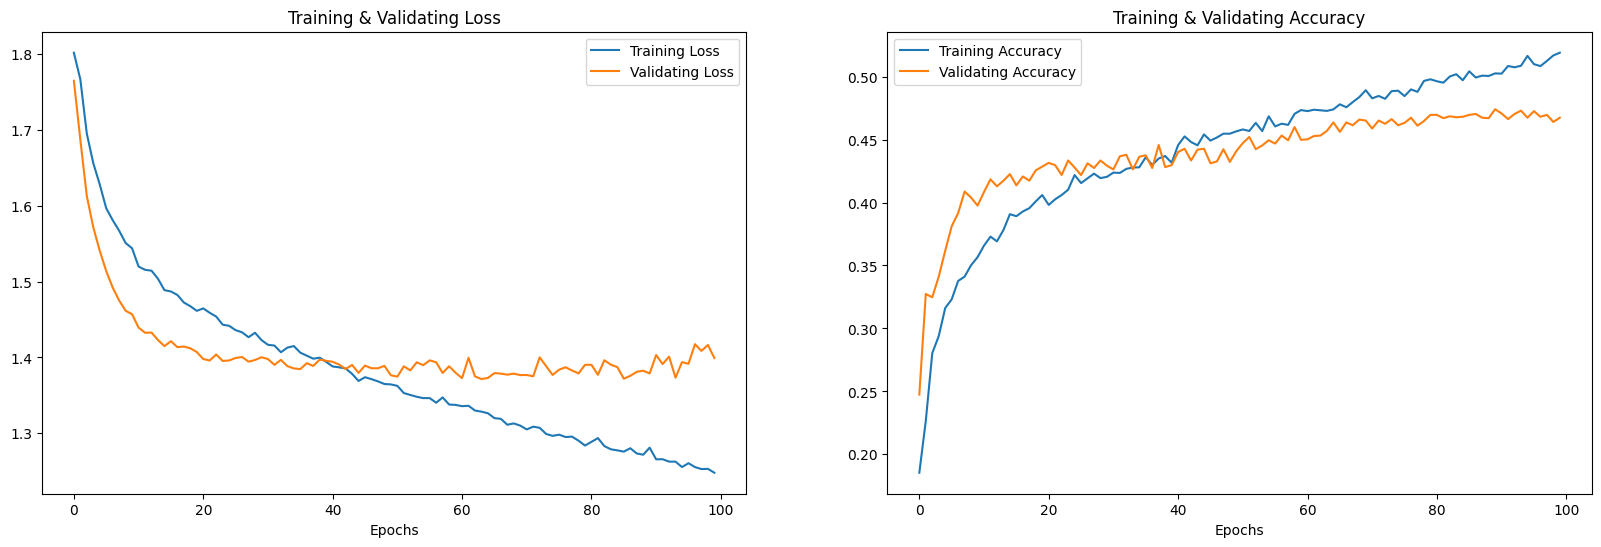

In [25]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy: ", test_acc*100 , "%")


epochs = [i for i in range(EPOCHS)]
fig, ax = plt.subplots(1, 2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.set_size_inches(20, 6)
ax[0].plot(epochs, train_loss, label='Training Loss')
ax[0].plot(epochs, val_loss, label='Validating Loss')
ax[0].set_title('Training & Validating Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs, train_acc, label='Training Accuracy')
ax[1].plot(epochs, val_acc, label='Validating Accuracy')
ax[1].set_title('Training & Validating Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [28]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
label_names = list(labels.keys())
print(classification_report(y_test, y_pred, target_names=label_names))

              precision    recall  f1-score   support

     neutral       0.48      0.65      0.55       235
       happy       0.47      0.42      0.45       246
     disgust       0.46      0.26      0.33       277
       angry       0.66      0.65      0.65       247
         sad       0.51      0.71      0.59       255
        fear       0.37      0.31      0.34       229

    accuracy                           0.50      1489
   macro avg       0.49      0.50      0.49      1489
weighted avg       0.49      0.50      0.48      1489



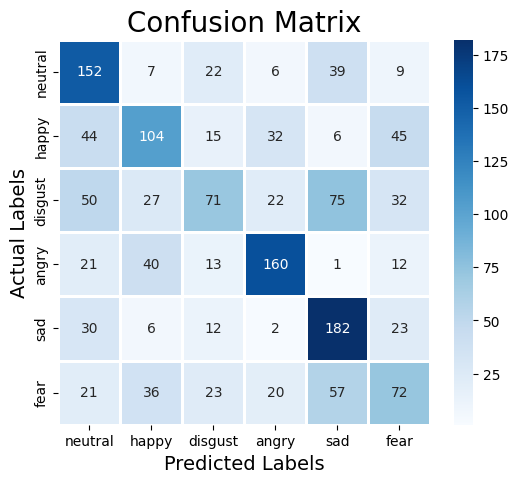

In [27]:
cm = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(cm)

plt.figure(figsize = (6, 5))
sns.heatmap(cm, xticklabels=label_names, yticklabels=label_names, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()